# Merge WUI and UNSC Data (1990-2023)

This notebook:
1. Loads WUI quarterly data and filters to 1990-2023
2. Loads UNSC resolutions data (1990-2023)
3. Merges the datasets by quarter
4. Creates summary statistics and visualizations
5. Saves the merged dataset for modeling

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Step 1: Load and Update WUI Data to 1990-2023

In [6]:
# Load the WUI data
wui_file = 'data/wui_quarterly_clean.csv'
df_wui = pd.read_csv(wui_file)

In [7]:
# Rename columns from CSV (date, WUI) to our naming convention (quarter, wui)
df_wui.columns = ['quarter', 'wui']

# Convert quarter to Period for proper filtering
df_wui['quarter'] = pd.PeriodIndex(df_wui['quarter'], freq='Q')

# Filter to 1990-2023 only
df_wui_filtered = df_wui[
    (df_wui['quarter'] >= '1990Q1') & 
    (df_wui['quarter'] <= '2023Q4')
].copy()

print(f" Filtered WUI data (1990-2023):")
print(f"   Quarters: {len(df_wui_filtered)}")
print(f"   Period: {df_wui_filtered['quarter'].min()} to {df_wui_filtered['quarter'].max()}")
print(f"\n   First quarter: {df_wui_filtered.iloc[0]['quarter']} | WUI: {df_wui_filtered.iloc[0]['wui']:.2f}")
print(f"   Last quarter: {df_wui_filtered.iloc[-1]['quarter']} | WUI: {df_wui_filtered.iloc[-1]['wui']:.2f}")

# Save updated WUI data
output_wui = 'data/wui_quarterly_1990_2023.csv'
df_wui_filtered.to_csv(output_wui, index=False)
print(f"\n Saved to: {output_wui}")

 Filtered WUI data (1990-2023):
   Quarters: 136
   Period: 1990Q1 to 2023Q4

   First quarter: 1990Q1 | WUI: 12496.47
   Last quarter: 2023Q4 | WUI: 16655.52

 Saved to: data/wui_quarterly_1990_2023.csv


## Step 2: Load UNSC Data

In [8]:
# Load UNSC data
unsc_file = 'data/unsc_resolutions_1990_2023.csv'
df_unsc = pd.read_csv(unsc_file)

# Convert quarter to Period
df_unsc['quarter'] = pd.PeriodIndex(df_unsc['quarter'], freq='Q')

# Create text_length column if it doesn't exist
if 'text_length' not in df_unsc.columns:
    df_unsc['text_length'] = df_unsc['text'].str.len()

print(f"UNSC data (1990-2023):")
print(f"   Resolutions: {len(df_unsc)}")
print(f"   Period: {df_unsc['quarter'].min()} to {df_unsc['quarter'].max()}")
print(f"   Columns: {len(df_unsc.columns)}")

# Basic statistics per quarter
quarterly_stats = df_unsc.groupby('quarter').agg({
    'res_no': 'count',
    'text_length': ['mean', 'sum']
}).round(0)
quarterly_stats.columns = ['n_resolutions', 'avg_text_length', 'total_text_length']

print(f"\nSample quarterly statistics:")
print(quarterly_stats.head(10))

UNSC data (1990-2023):
   Resolutions: 2075
   Period: 1990Q1 to 2023Q4
   Columns: 84

Sample quarterly statistics:
         n_resolutions  avg_text_length  total_text_length
quarter                                                   
1990Q1               5           1818.0               9088
1990Q2               7           1447.0              10132
1990Q3              13           2616.0              34003
1990Q4              12           2177.0              26123
1991Q1               3           2696.0               8087
1991Q2              14           3555.0              49770
1991Q3              14           2640.0              36958
1991Q4              11           2329.0              25620
1992Q1              23           2270.0              52214
1992Q2              14           3374.0              47231


## Step 3: Merge Datasets by Quarter

In [9]:
# Merge WUI and quarterly UNSC statistics
df_merged = df_wui_filtered.merge(
    quarterly_stats, 
    left_on='quarter', 
    right_index=True, 
    how='left'
)

df_merged['n_resolutions'] = df_merged['n_resolutions'].fillna(0).astype(int)
df_merged['avg_text_length'] = df_merged['avg_text_length'].fillna(0)
df_merged['total_text_length'] = df_merged['total_text_length'].fillna(0)

print("f Merged dataset:")
print(f"   Rows (quarters): {len(df_merged)}")
print(f"   Columns: {df_merged.columns.tolist()}")

print(f"\nSummary statistics:")
print(df_merged.describe())

print(f"\n Sample data:")
print(df_merged.head(10).to_string())

f Merged dataset:
   Rows (quarters): 136
   Columns: ['quarter', 'wui', 'n_resolutions', 'avg_text_length', 'total_text_length']

Summary statistics:
                wui  n_resolutions  avg_text_length  total_text_length
count    136.000000     136.000000       136.000000         136.000000
mean   17878.522500      15.257353     12250.551471      182964.316176
std     9013.481644       4.537900      8361.694168      128021.282646
min     5569.941000       3.000000      1447.000000        8087.000000
25%    11794.780000      13.000000      5737.750000       91842.000000
50%    15300.260000      15.000000      9607.500000      136627.500000
75%    22392.722500      18.000000     17203.750000      248366.500000
max    55684.710000      31.000000     50682.000000      603685.000000

 Sample data:
  quarter        wui  n_resolutions  avg_text_length  total_text_length
0  1990Q1  12496.470              5           1818.0               9088
1  1990Q2   8769.965              7           1447.

In [10]:
# Check for quarters with no resolutions
no_resolutions = df_merged[df_merged['n_resolutions'] == 0]
print(f"\n Quarters with NO resolutions: {len(no_resolutions)} / {len(df_merged)}")
if len(no_resolutions) > 0:
    print(f"\nQuarters without resolutions:")
    print(no_resolutions[['quarter', 'wui', 'n_resolutions']].to_string())


 Quarters with NO resolutions: 0 / 136


## Step 4: Visualization - WUI vs UNSC Activity

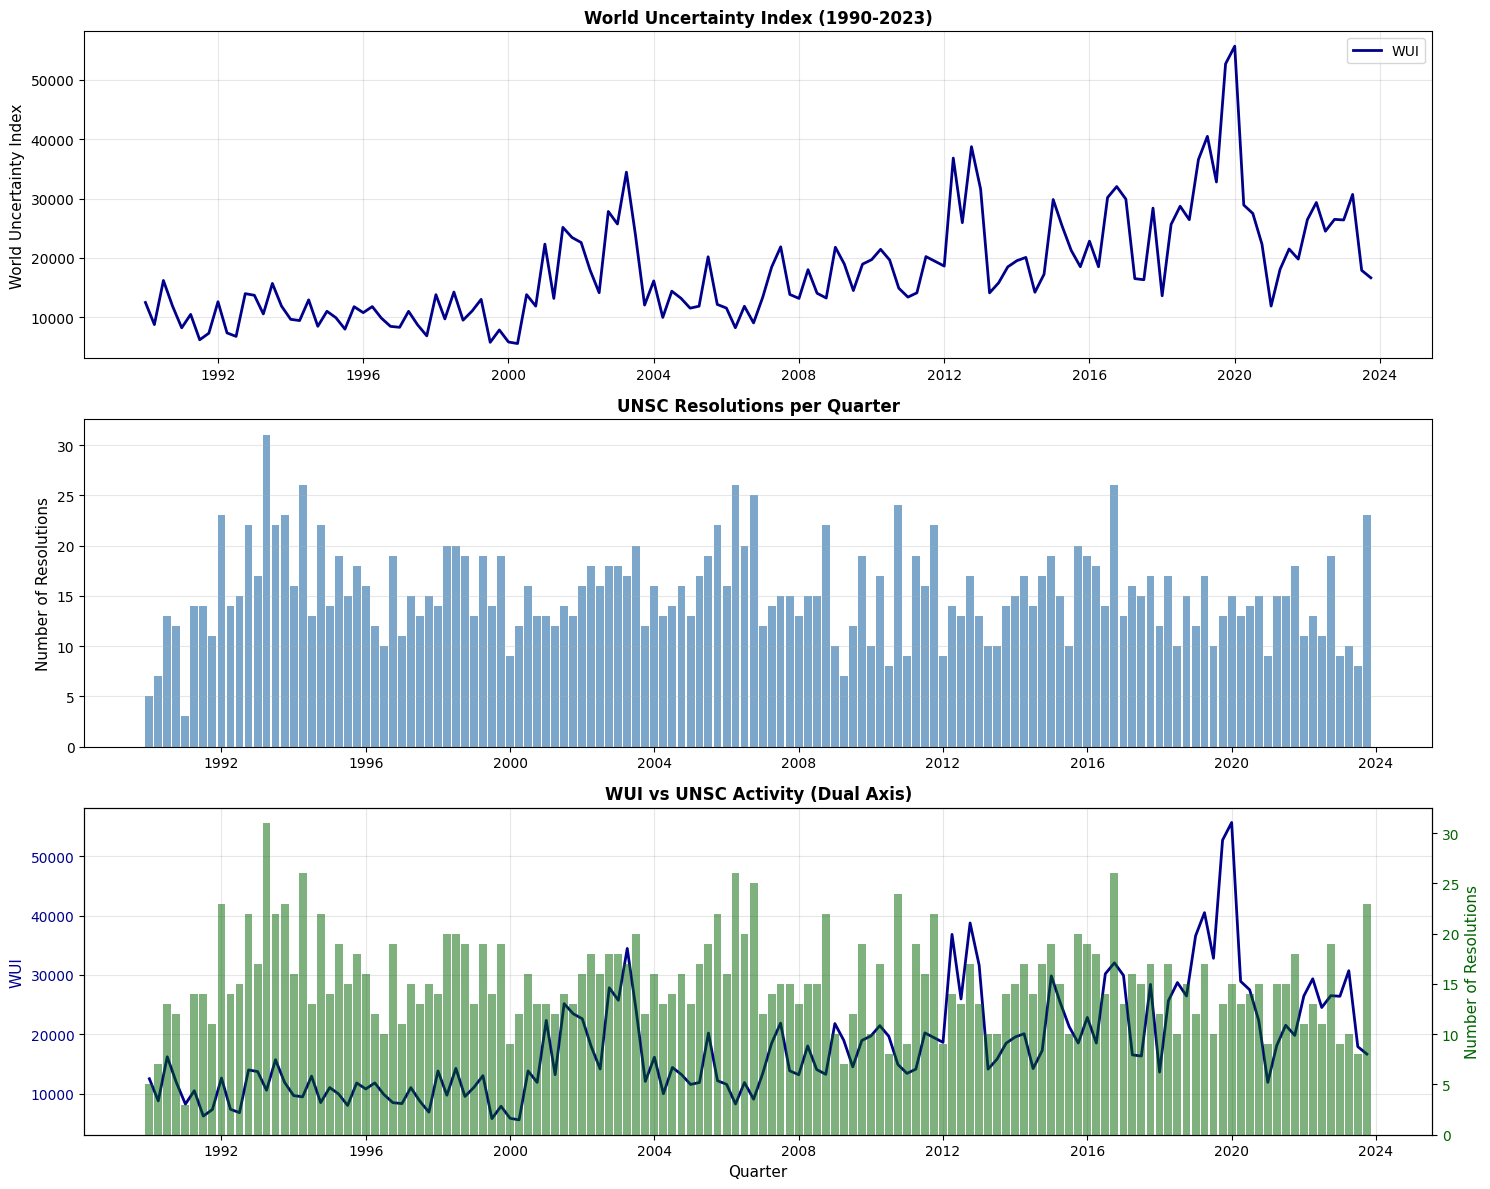

In [11]:
# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Convert quarter to timestamp for plotting
quarters_ts = df_merged['quarter'].dt.to_timestamp()

# Plot 1: WUI over time
axes[0].plot(quarters_ts, df_merged['wui'], linewidth=2, color='darkblue', label='WUI')
axes[0].set_ylabel('World Uncertainty Index', fontsize=11)
axes[0].set_title('World Uncertainty Index (1990-2023)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Number of resolutions per quarter
axes[1].bar(quarters_ts, df_merged['n_resolutions'], alpha=0.7, color='steelblue', width=80)
axes[1].set_ylabel('Number of Resolutions', fontsize=11)
axes[1].set_title('UNSC Resolutions per Quarter', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Dual axis - WUI and UNSC activity together
ax3 = axes[2]
color1 = 'darkblue'
ax3.plot(quarters_ts, df_merged['wui'], linewidth=2, color=color1, label='WUI')
ax3.set_ylabel('WUI', color=color1, fontsize=11)
ax3.tick_params(axis='y', labelcolor=color1)

ax3_twin = ax3.twinx()
color2 = 'darkgreen'
ax3_twin.bar(quarters_ts, df_merged['n_resolutions'], alpha=0.5, color=color2, width=80, label='Resolutions')
ax3_twin.set_ylabel('Number of Resolutions', color=color2, fontsize=11)
ax3_twin.tick_params(axis='y', labelcolor=color2)

axes[2].set_title('WUI vs UNSC Activity (Dual Axis)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Quarter', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Correlation Analysis

In [12]:
# Basic correlation between WUI and UNSC activity
correlation = df_merged[['wui', 'n_resolutions', 'avg_text_length']].corr()

print("=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
print(correlation.to_string())

print(f"\n\nKEY INSIGHTS:")
print(f"   WUI ↔ Number of resolutions: {correlation.loc['wui', 'n_resolutions']:.3f}")
print(f"   WUI ↔ Avg text length: {correlation.loc['wui', 'avg_text_length']:.3f}")

CORRELATION MATRIX
                      wui  n_resolutions  avg_text_length
wui              1.000000      -0.065922         0.507054
n_resolutions   -0.065922       1.000000        -0.104779
avg_text_length  0.507054      -0.104779         1.000000


KEY INSIGHTS:
   WUI ↔ Number of resolutions: -0.066
   WUI ↔ Avg text length: 0.507


## Step 6: Save Merged Dataset

In [13]:
# Save the merged dataset
output_merged = 'data/wui_unsc_merged_1990_2023.csv'
df_merged.to_csv(output_merged, index=False)

print(f" SAVED merged dataset {output_merged}")

 SAVED merged dataset data/wui_unsc_merged_1990_2023.csv
